In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [9]:
#afisam data setul water_problem trebuie sa punem encoding ca sa ne afiseze cu litere latine
df = pd.read_csv('water_problem_nlp_en_for_Kaggle_100.csv', sep=';')
df

,text,env_problems,pollution,treatment,climate,biomonitoring
0,In the Southern Bug basin wastewater is discha...,1,1.0,NaN,NaN,NaN
1,This amount is distributed as follows: urban a...,1,1.0,NaN,NaN,NaN
2,Despite the similar volumes of discharged wast...,1,1.0,NaN,NaN,NaN
3,They bring 84% of organic pollution 86% of pho...,1,1.0,NaN,NaN,NaN
4,The input of the industry is between 7–21% and...,1,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...
95,Chemical composition of water bodies shall com...,0,NaN,NaN,NaN,NaN
96,According to the Directive provisions water bo...,0,NaN,NaN,NaN,NaN
97,Besides in the field of data processing during...,0,NaN,NaN,NaN,NaN
98,Use of these values was offered by the Monitor...,0,NaN,NaN,NaN,NaN


In [10]:
#procesarea textului, trebuie sa importam clasele
from sklearn.base import BaseEstimator, TransformerMixin

In [11]:
# modul 1, normalizare     
#self obiectul care cheama functia
class TextNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
#x este un string
    def transform(self, X, y=None):
        #creem o copie
        X_copy = X.copy()
        for i in range(len(X_copy)):
            X_copy[i] = X_copy[i].lower()              
# scoatem new linerulie
            X_copy[i] = X_copy[i].replace('\n', ' ')
            X_copy[i] = X_copy[i].replace('\r', ' ')
# functia strip scoate din stinga si dreapta spatiile
            X_copy[i] = X_copy[i].strip()    
        return X_copy

In [12]:
X = df['text'].values
y = df['env_problems'].values

In [13]:
X

array(['In the Southern Bug basin wastewater is discharged from 341 organized sources (Map 5). In 2011 (reference year) 211 mln. m3 was discharged in total.',
       'This amount is distributed as follows: urban and rural housing wastewater treatment facilities (WWTPs - vodocanals) – 70 mln. m3 (57 users) industry – 50 mln. m3 (79 users) agriculture – 90 mln. m3 (193 users) other users – 1 mln. m3 (12 users) (Picture. 2.1). ',
       'Despite the similar volumes of discharged wastewater major part of pollutants comes with communal WWTPs.',
       'They bring 84% of organic pollution 86% of phosphate ions and 84% of mineral nitrogen 91% of ammonia nitrogen 87% nitrate nitrogen and 79% nitrite nitrogen.',
       'The input of the industry is between 7–21% and agriculture has the lowest impact on water bodies - 0–6%. Of the 92 urban areas only 51 localities (55%) have centralized collection of communal waste waters and their monitoring. Among the 2878 villages 6 of them (0.2%) have such a

In [14]:
#trebuie sa cautam hapacsele
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [15]:
class WordExctractor(BaseEstimator, TransformerMixin): #gaseste hapaxele si  
    def __init__(self, language, tokenize):
        self.language = language
        self.stopwords = stopwords.words(self.language)
        self.tokenize = tokenize
        
    def fit(self, X, y=None):
        general_freq = FreqDist()
        for txt in X:
            freq_dist = FreqDist(self.tokenize(txt)) #freq_dist calculeaza distributia pe toate textele
            general_freq.update(freq_dist)
        self.hapaxes = general_freq.hapaxes()
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()
        for i in range(len(X_copy)):
            X_copy[i] = ' '.join([token for token in self.tokenize(X_copy[i])
                if token not in self.stopwords and token not in self.hapaxes])
        return X_copy

In [16]:
#Pas 3. aplicam steemer
class ApplyStemmer(BaseEstimator, TransformerMixin):
    def __init__(self, stemmer, tokenize):
        self.stemmer = stemmer
        self.tokenize = tokenize
        
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        for i in range(len(X_copy)):
            X_copy[i] = ' '.join([self.stemmer.stem(token)
                    for token in self.tokenize(X_copy[i])])
        return X_copy

In [17]:
# vedem rezultatul cu Pipeline si LogisticRegression

In [18]:
#unim toate componenetele impreuna cu sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [19]:
pipe = Pipeline([
    ('Normalization', TextNormalizer()),
    ('Word Extraction', WordExctractor('english', word_tokenize)),
    ('Apply Stemmer', ApplyStemmer(PorterStemmer(), word_tokenize)),
    ('Vectorizarion', CountVectorizer()),
    ('Model', LogisticRegression())
])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('Normalization', TextNormalizer()),
                ('Word Extraction',
                 WordExctractor(language='english',
                                tokenize=<function word_tokenize at 0x0000011218207E58>)),
                ('Apply Stemmer',
                 ApplyStemmer(stemmer=<PorterStemmer>,
                              tokenize=<function word_tokenize at 0x0000011218207E58>)),
                ('Vectorizarion', CountVectorizer()),
                ('Model', LogisticRegression())])

In [22]:
y_pred = pipe.predict(X_test)

In [23]:
y_pred

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0], dtype=int64)

In [24]:
accuracy_score(y_pred, y_test)

0.88

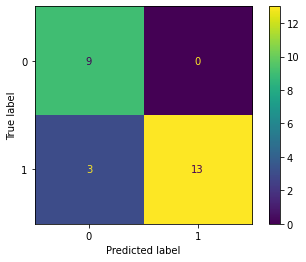

In [25]:
plot_confusion_matrix(pipe, X_test, y_test)

In [26]:
#aflam rezulatul cu KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

In [27]:
kne = Pipeline([
    ('Normalization', TextNormalizer()),
    ('Word Extraction', WordExctractor('english', word_tokenize)),
    ('Apply Stemmer', ApplyStemmer(PorterStemmer(), word_tokenize)),
    ('Vectorizarion', CountVectorizer()),
    ('Model', KNeighborsClassifier())
])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [29]:
kne.fit(X_train, y_train)

Pipeline(steps=[('Normalization', TextNormalizer()),
                ('Word Extraction',
                 WordExctractor(language='english',
                                tokenize=<function word_tokenize at 0x0000011218207E58>)),
                ('Apply Stemmer',
                 ApplyStemmer(stemmer=<PorterStemmer>,
                              tokenize=<function word_tokenize at 0x0000011218207E58>)),
                ('Vectorizarion', CountVectorizer()),
                ('Model', KNeighborsClassifier())])

In [30]:
y_pred = kne.predict(X_test)

In [31]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0], dtype=int64)

In [32]:
accuracy_score(y_pred, y_test)

0.52

In [33]:
# train accuracy
accuracy_score(y_train, y_train)

1.0

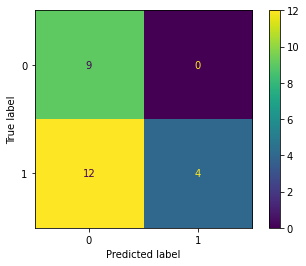

In [34]:
plot_confusion_matrix(kne, X_test, y_test)

In [35]:
#aflam rezultatele cu DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

In [36]:
decision = Pipeline([
    ('Normalization', TextNormalizer()),
    ('Word Extraction', WordExctractor('english', word_tokenize)),
    ('Apply Stemmer', ApplyStemmer(PorterStemmer(), word_tokenize)),
    ('Vectorizarion', CountVectorizer()),
    ('Model', DecisionTreeClassifier())
])

In [37]:
decision.fit(X_train, y_train)

Pipeline(steps=[('Normalization', TextNormalizer()),
                ('Word Extraction',
                 WordExctractor(language='english',
                                tokenize=<function word_tokenize at 0x0000011218207E58>)),
                ('Apply Stemmer',
                 ApplyStemmer(stemmer=<PorterStemmer>,
                              tokenize=<function word_tokenize at 0x0000011218207E58>)),
                ('Vectorizarion', CountVectorizer()),
                ('Model', DecisionTreeClassifier())])

In [38]:
y_pred = decision.predict(X_test)

In [39]:
y_pred

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0], dtype=int64)

In [40]:
accuracy_score(y_pred, y_test)

0.88

In [41]:
# train accuracy
accuracy_score(y_train, y_train)

1.0

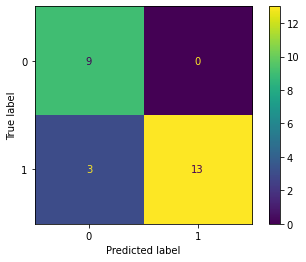

In [42]:
plot_confusion_matrix(decision, X_test, y_test)

In [43]:
# aflam rezultatele cu RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [44]:
random = Pipeline([
    ('Normalization', TextNormalizer()),
    ('Word Extraction', WordExctractor('english', word_tokenize)),
    ('Apply Stemmer', ApplyStemmer(PorterStemmer(), word_tokenize)),
    ('Vectorizarion', CountVectorizer()),
    ('Model', RandomForestClassifier())
])

In [45]:
random.fit(X_train, y_train)

Pipeline(steps=[('Normalization', TextNormalizer()),
                ('Word Extraction',
                 WordExctractor(language='english',
                                tokenize=<function word_tokenize at 0x0000011218207E58>)),
                ('Apply Stemmer',
                 ApplyStemmer(stemmer=<PorterStemmer>,
                              tokenize=<function word_tokenize at 0x0000011218207E58>)),
                ('Vectorizarion', CountVectorizer()),
                ('Model', RandomForestClassifier())])

In [46]:
y_pred = random.predict(X_test)

In [47]:
y_pred

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0], dtype=int64)

In [48]:
accuracy_score(y_pred, y_test)

0.88

In [49]:
# train accuracy
accuracy_score(y_train, y_train)

1.0

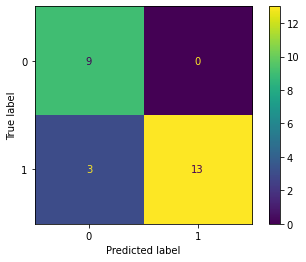

In [50]:
plot_confusion_matrix(random, X_test, y_test)